In [1]:
import sys
sys.path.append(r'..\scripts')

import numpy as np

## Kernel

### Compute Kernel if not cached

In [83]:
from compute_kernels import parallel_Li, Li

In [49]:
#Define simulation parameters

N = 120 # Number of spatial points
zb, zt = 1, 5 #bounds
k = 1 #wave number
alpha = 4.8
dz = (zt - zb)/N

#Radius function
R = lambda z : 3 - 4.8 * ((z - .5 * (zb + zt))/(zt - zb))**2
R = np.vectorize(R)

if __name__ == '__main__':
    zg, oc, L = parallel_Li(zb, zt, N, k, R, num_workers = None)

In [50]:
np.savez(f'../data_cache/discretizationN={N}_k={k}_R=EandM.npz', zg=zg, oc=oc, L=L)

### Load Cached Kernel

In [2]:
#Define simulation parameters
N = 120 # Number of spatial points
zb, zt = 1, 5 #bounds
k = 2 #wave number
alpha = 4.8
dz = (zt - zb)/N

#Radius function
R = lambda z : 1
R = np.vectorize(R)

discretization = np.load(f'../data_cache/discretizationN={N}.npz')
zg, oc, Li = discretization['zg'], discretization['oc'], discretization['L']

## Visual Experiments

In [3]:
from steady_state_analysis import compute_eta_decomp, dDelta_dt_from_Delta, inner_product, compute_dDelta_dt_from_range_Delta, generate_contours
from dynamical_system import F_k, dDelta_dt, deta_dt
from simulation import generate_and_show_plots, simualte
import matplotlib.pyplot as plt
from scipy.linalg import eig

In [30]:
gamma = 0.1
S_hat = 50
delta_hat = 0.1
kappa = 2
Delta_E = np.vectorize(lambda z: 0.5)

In [31]:
#Load Values
generate_plots = True
save = False
Delta0_func = lambda z : 1
eta0_func = lambda z : 1 + 0j
T_final = 300
try: 
    steady_states = np.load(f'../data_cache/steady_state_N={N}_S_hat={S_hat}_delta_hat={delta_hat}_kappa={kappa}_gamma={gamma}.npz')
    zg, sol_Delta, sol_eta = steady_states['zg'], steady_states['sol_Delta'], steady_states['sol_eta']
except FileNotFoundError:
    if generate_plots:
        sol_Delta, sol_eta = generate_and_show_plots(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, zg, solver='RK45', levels = 30)
    else:
        sol_Delta, sol_eta = simulate(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, zg, solver='RK45')

    if save:
        np.savez(f'../data_cache/steady_state_N={N}_S_hat={S_hat}_delta_hat={delta_hat}_kappa={kappa}_gamma={gamma}.npz', zg = zg, sol_Delta = sol_Delta, sol_eta = sol_eta)

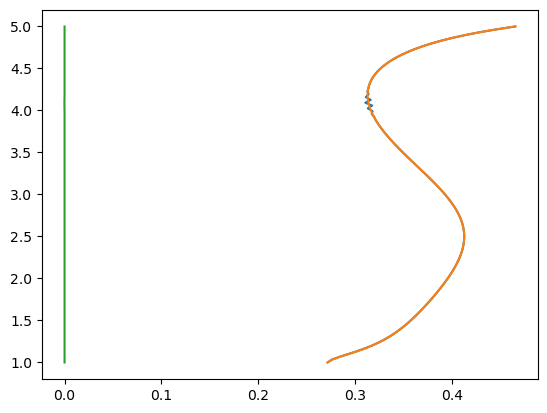

In [ ]:
#compute single \eta 
Delta = sol_Delta[:, -1]
#Delta = vecced_delta[95]
eta, A_ns, eigenvalues, eigenvectors = compute_eta_decomp(Delta, Li, oc, S_hat, delta_hat, F_k, R, zg, k, num_eigenvalues = N)

plt.plot(np.abs(sol_eta[:, -1]), zg)
plt.plot(np.abs(eta), zg)

plt.plot(dDelta_dt_from_Delta(Delta, Delta_E, S_hat, delta_hat, gamma, kappa, Li, oc, F_k, R, zg, k, num_eigenvalues = N)[0], zg)

In [ ]:
#multiple Deltas
#Delta = lambda b: np.exp(1j * b * zg).imag * 0 + b
#b_grid = np.linspace(0, 1, 100)
#vecced_delta = np.array([Delta(b) for b in b_grid])

x_axis_level = N//2
Delta = sol_Delta[:, -1]
b_grid = np.linspace(0, 1/Delta[x_axis_level], 100)
vecced_delta = np.array([Delta * b for b in b_grid])

dDelta_all, eigenvalues_all, eigenvectors_all =  compute_dDelta_dt_from_range_Delta(vecced_delta, Delta_E, S_hat, delta_hat, gamma, kappa, Li, oc, F_k, R, zg, k, num_eigenvalues = N)

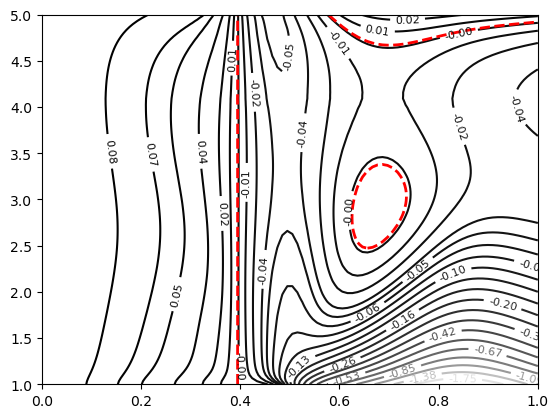

In [ ]:
generate_contours(dDelta_all, vecced_delta, zg, x_axis_level)

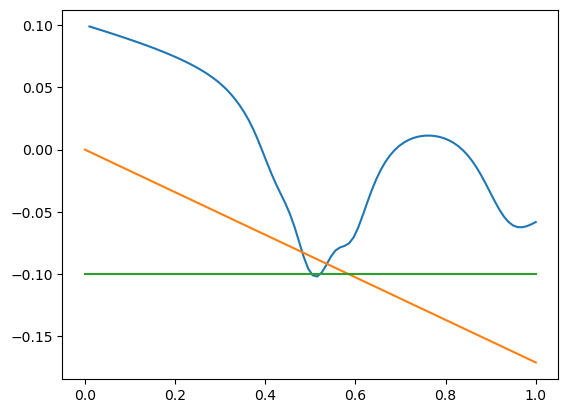

In [716]:
plt.plot(vecced_delta[:, N//2], dDelta_all[:, N//2])
plt.plot(vecced_delta[:, N//2], eigenvalues_all[:, 1])
plt.plot(vecced_delta[:, N//2], np.ones(100) * -delta_hat)

In [688]:
def compute_interaction(eigenvalue_1, eigenvalue_2):
    #return ((eigenvalue_1 + delta_hat) - 1/(1j * S_hat)) * np.conj((eigenvalue_2 + delta_hat) - 1/(1j * S_hat))
    return (eigenvalue_1 + delta_hat) * (eigenvalue_2 + delta_hat) + 1/(S_hat)**2 - 1j/S_hat*(eigenvalue_2 + delta_hat) + 1j/S_hat*(eigenvalue_1 + delta_hat) #these interaction terms actually cancel since we have double but with eigenvealues flipped, if this makes sense

In [703]:
Fk = np.vectorize(F_k)(R, zg, k)
def one_term(arr_idx, idx_1, idx_2):
    eigenvalue_1 = eigenvalues_all[arr_idx][idx_1]
    eigenvalue_2 = eigenvalues_all[arr_idx][idx_2]
    eigenvector_1= eigenvectors_all[arr_idx][:, idx_1]
    eigenvector_2 = eigenvectors_all[arr_idx][:, idx_2]
    inner_prod = inner_product(1j * Fk, eigenvector_1, R, vecced_delta[arr_idx], zg) * np.conj(inner_product(1j * Fk, eigenvector_2, R, vecced_delta[arr_idx], zg))
    A_n_term = -inner_prod/(compute_interaction(eigenvalue_1, eigenvalue_2))
    return A_n_term * eigenvector_1 * np.conj(eigenvector_2)

In [704]:
interactions = np.ones((eigenvalues_all.shape[1], eigenvalues_all.shape[1]), dtype=np.complex128) * np.nan
for i, eigenvalue_1 in enumerate(eigenvalues_all[95]):
    for j, eigenvalue_2 in enumerate(eigenvalues_all[95]):
        interactions[i, j] = compute_interaction(eigenvalue_1, eigenvalue_2)

In [705]:
sub_array = interactions

# Flatten the sliced array and get indices of the smallest 5 values
flat_indices = np.argsort(sub_array, axis=None)[:1]

# Convert the flat indices back to coordinates in the original array
top_min_indices = [np.unravel_index(idx, sub_array.shape) for idx in flat_indices]

# Adjust indices to account for the slice
#top_min_indices = [(i + 0, j + 0) for i, j in top_min_indices]

In [706]:
contributing_terms = [one_term(95, i, j) for (i, j) in top_min_indices]

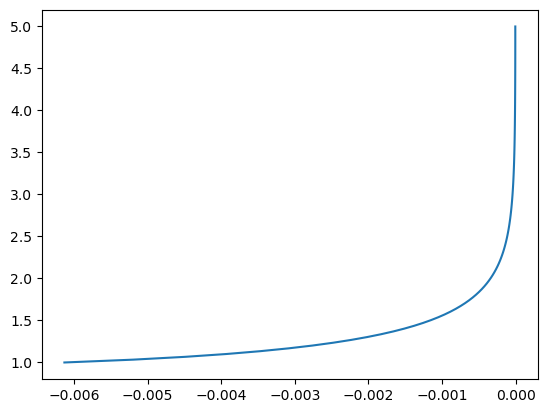

In [707]:
plt.plot(np.sum(contributing_terms, axis=0)/S_hat**2, zg)

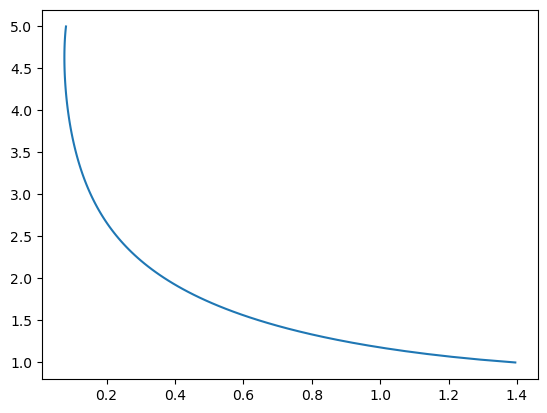

In [694]:
plt.plot(np.abs(eta), zg)

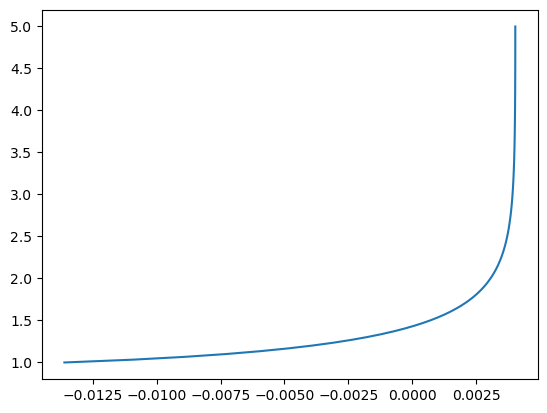

In [660]:
plt.plot(gamma * (Delta_E/np.max(Delta_E) - vecced_delta[95] - vecced_delta[95] * kappa/S_hat**2 * np.sum(contributing_terms, axis=0)), zg)

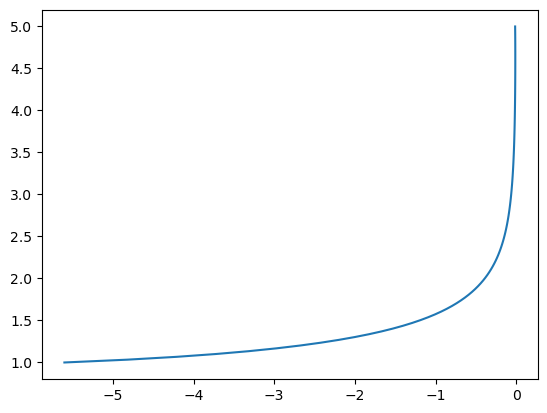

In [661]:
plt.plot(dDelta_all[95], zg)

In [251]:
dDelta_all = np.array([result[0] for result in res]) 

dDelta_projections = []
Delta_projections =[]
for i, result in enumerate(res):
    dDelta = result[0]
    eigenvalue = result[1]
    eigenvectors = result[2]
    #dDelta_projections.append(inner_product(dDelta, eigenvectors[:, 1], R, vecced_delta[i], zg))
    #Delta_projections.append(inner_product(vecced_delta[i], eigenvectors[:, 1], R, vecced_delta[i], zg))
    dDelta_projections.append(dDelta[N//2])
    Delta_projections.append(vecced_delta[i, N//2])


In [245]:
zero_coords = []
for path in zero_contour.collections[0].get_paths():
    vertices = path.vertices
    zero_coords.append(vertices)

C:\Users\MikeTyrrell\AppData\Local\Temp\ipykernel_40340\702686078.py:2: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for path in zero_contour.collections[0].get_paths():


In [246]:
Delta_at_0 = np.array([(delta, z_val) for delta, z_val in zip(zero_coords[0][:, 0], zg)])[:, 0]

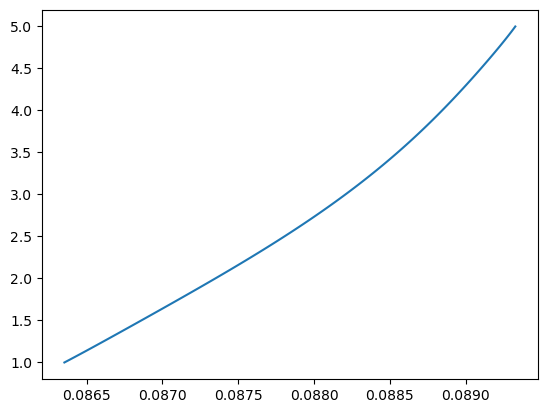

In [377]:
plt.plot(dDelta_all[10, :], zg)

## Compute Steady States

In [ ]:
from steady_state_analysis import compute_adomian_decomp_terms, pseudo_arclength_continutation, compute_steady_state
from simulation import simulate
from dynamical_system import F_k
import matplotlib.pyplot as plt

### Pseudo-Arclength

In [ ]:
#Default Parameters
T_final = 300
gamma = 0.1
S_hat = 100
delta_hat = 0.1
kappa = 30
Delta0_func = lambda z : 1
eta0_func = lambda z : 1 + 0j
Delta_E = np.vectorize(lambda z : 0.5)

sol_T, sol_Delta, sol_eta = simulate(kappa, gamma, S_hat, delta_hat, Delta0_func, eta0_func, Delta_E, R, k, zb, zt, N, T_final, Li, oc, solver='BDF')

In [ ]:
#Initial guess for state variable is 
z0 = np.concatenate([sol_Delta[:, -1], sol_eta[:, -1]]) # Initial guess for state variables
lambda0 = np.array([100])  # Initial guess for parameter vector (3 components)
zlambd0 = np.concatenate([z0, lambda0])

# Parameters for continuation
s0 = 0.0  # Initial arclength
ds = 2  # Arclength increment
num_steps = 100  # Number of continuation steps

dz = (zt - zb)/N

function_params = (L, oc, Delta_E(zg), F_k(R, zg, k)) #gamma, L, oc, DeltaE, Fk, N, dz 

# Perform continuation
results, convergence = pseudo_arclength_continuation(zlambd0, function_params, N, dz, ds, S_hat = S_hat, delta_hat = delta_hat, kappa = kappa, gamma=gamma, max_steps=num_steps, jac_epislon=1e-8)

np.savez(f'SteadyStatesVaringKappaPseudoArc.npz', results = results, convergence=convergence) 

results
